# SymForce "Hello World"

Replication of the PGO example(s) found on the [SymForce main page](https://symforce.org/).

In [1]:
"""
Demonstrates solving a 3D localization problem with SymForce. A robot moving
in 3D performs scan matching and gets relative translation constraints to landmarks
in the environment. It also has odometry constraints between its poses. The goal is
to estimate the trajectory of the robot given known landmarks and noisy measurements.
"""

# -----------------------------------------------------------------------------
# Set the default epsilon to a symbol
# -----------------------------------------------------------------------------
import symforce

symforce.set_epsilon_to_symbol()

# -----------------------------------------------------------------------------
# Create initial Values
# -----------------------------------------------------------------------------
import numpy as np

from symforce import typing as T
from symforce.values import Values


def build_values(num_poses: int) -> T.Tuple[Values, int]:
    np.random.seed(42)

    # Create a problem setup and initial guess
    values = Values()

    # Create sample ground-truth poses
    gt_world_T_body = []
    for i in range(num_poses):
        # Pick a nonlinear shape of motion to make it interesting
        t = i / num_poses
        tangent_vec = np.array(
            [
                -1 * t,
                -2 * t,
                -3 * t,
                8 * np.sin(t * np.pi / 1.3),
                9 * np.sin(t * np.pi / 2),
                5 * np.sin(t * np.pi / 1.8),
            ]
        )
        gt_world_T_body.append(sym.Pose3.from_tangent(tangent_vec, epsilon=sf.numeric_epsilon))

    # Set the initial guess either to ground truth or identity
    use_gt_poses = False
    if use_gt_poses:
        values["world_T_body"] = gt_world_T_body
    else:
        values["world_T_body"] = [sym.Pose3.identity() for _ in range(num_poses)]

    # Set landmark locations
    values["world_t_landmark"] = [
        np.random.uniform(low=0.0, high=10.0, size=3) for _ in range(NUM_LANDMARKS)
    ]
    num_landmarks = len(values["world_t_landmark"])

    # Set odometry measurements
    values["odometry_diagonal_sigmas"] = np.array([0.05, 0.05, 0.05, 0.2, 0.2, 0.2])
    values["odometry_relative_pose_measurements"] = []
    for i in range(num_poses - 1):
        # Get ground truth
        gt_relative_pose = gt_world_T_body[i].inverse() * gt_world_T_body[i + 1]

        # Perturb
        tangent_perturbation = np.random.normal(size=6) * values["odometry_diagonal_sigmas"]
        relative_pose_meas = gt_relative_pose.retract(tangent_perturbation)

        values["odometry_relative_pose_measurements"].append(relative_pose_meas)

    # Set landmark measurements
    values["matching_sigma"] = 0.1
    values["body_t_landmark_measurements"] = np.zeros((num_poses, num_landmarks, 3))
    for i in range(num_poses):
        for j in range(num_landmarks):
            # Get ground truth
            gt_body_t_landmark = gt_world_T_body[i].inverse() * values["world_t_landmark"][j]

            # Perturb
            perturbation = np.random.normal(scale=values["matching_sigma"], size=3)
            body_t_landmark_meas = gt_body_t_landmark + perturbation

            values["body_t_landmark_measurements"][i, j, :] = body_t_landmark_meas

    # Turn first two axes into python lists so they are individual keys, not part of a tensor
    values["body_t_landmark_measurements"] = list(
        list(m) for m in values["body_t_landmark_measurements"]
    )

    values["epsilon"] = sf.numeric_epsilon

    return values, num_landmarks


# -----------------------------------------------------------------------------
# Define residual functions
# -----------------------------------------------------------------------------
import symforce.symbolic as sf
from symforce import logger

if symforce.get_symbolic_api() != "symengine":
    logger.warning("The 3D Localization example is very slow on sympy. Use symengine.")

NUM_POSES = 5
NUM_LANDMARKS = 20


def matching_residual(
    world_T_body: sf.Pose3, world_t_landmark: sf.V3, body_t_landmark: sf.V3, sigma: sf.Scalar
) -> sf.V3:
    """
    Residual from a relative translation mesurement of a 3D pose to a landmark.

    Args:
        world_T_body: 3D pose of the robot in the world frame
        world_t_landmark: World location of the landmark
        body_t_landmark: Measured body-frame location of the landmark
        sigma: Isotropic standard deviation of the measurement [m]
    """
    body_t_landmark_predicted = world_T_body.inverse() * world_t_landmark
    return (body_t_landmark_predicted - body_t_landmark) / sigma


def odometry_residual(
    world_T_a: sf.Pose3,
    world_T_b: sf.Pose3,
    a_T_b: sf.Pose3,
    diagonal_sigmas: sf.V6,
    epsilon: sf.Scalar,
) -> sf.V6:
    """
    Residual on the relative pose between two timesteps of the robot.

    Args:
        world_T_a: First pose in the world frame
        world_T_b: Second pose in the world frame
        a_T_b: Relative pose measurement between the poses
        diagonal_sigmas: Diagonal standard deviation of the tangent-space error
        epsilon: Small number for singularity handling
    """
    a_T_b_predicted = world_T_a.inverse() * world_T_b
    tangent_error = a_T_b_predicted.local_coordinates(a_T_b, epsilon=epsilon)
    return T.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))


# -----------------------------------------------------------------------------
# Create a set of factors to represent the full problem
# -----------------------------------------------------------------------------
from symforce.opt.factor import Factor


def build_factors(num_poses: int, num_landmarks: int) -> T.Iterator[Factor]:
    """
    Build factors for a problem of the given dimensionality.
    """
    for i in range(num_poses):
        for j in range(num_landmarks):
            yield Factor(
                residual=matching_residual,
                keys=[
                    f"world_T_body[{i}]",
                    f"world_t_landmark[{j}]",
                    f"body_t_landmark_measurements[{i}][{j}]",
                    "matching_sigma",
                ],
            )

    for i in range(num_poses - 1):
        yield Factor(
            residual=odometry_residual,
            keys=[
                f"world_T_body[{i}]",
                f"world_T_body[{i + 1}]",
                f"odometry_relative_pose_measurements[{i}]",
                "odometry_diagonal_sigmas",
                "epsilon",
            ],
        )


# -----------------------------------------------------------------------------
# Instantiate, optimize, and visualize
# -----------------------------------------------------------------------------
import sym
from symforce.opt.optimizer import Optimizer


def build_residual(num_poses: int, num_landmarks: int, values: Values) -> sf.Matrix:
    residuals: T.List[sf.Matrix] = []
    for i in range(num_poses):
        for j in range(num_landmarks):
            residuals.append(
                matching_residual(
                    values.attr.world_T_body[i],
                    values.attr.world_t_landmark[j],
                    values.attr.body_t_landmark_measurements[i][j],
                    values.attr.matching_sigma,
                )
            )

    for i in range(num_poses - 1):
        residuals.append(
            odometry_residual(
                values.attr.world_T_body[i],
                values.attr.world_T_body[i + 1],
                values.attr.odometry_relative_pose_measurements[i],
                values.attr.odometry_diagonal_sigmas,
                values.attr.epsilon,
            )
        )

    return sf.Matrix.block_matrix([[residual] for residual in residuals])


def main() -> None:
    num_poses = NUM_POSES

    values, num_landmarks = build_values(num_poses)

    for key, value in values.items_recursive():
        print(f"{key}: {value}")

    print(values.to_storage())

    # Create factors
    factors = build_factors(num_poses=num_poses, num_landmarks=num_landmarks)

    # Select the keys to optimize - the rest will be held constant
    optimized_keys = [f"world_T_body[{i}]" for i in range(num_poses)]

    # Create the optimizer
    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        # Return problem stats for every iteration
        debug_stats=True,
        # Customize optimizer behavior
        params=Optimizer.Params(verbose=True, initial_lambda=1e4, lambda_down_factor=1 / 2.0),
    )

    # Solve and return the result
    result = optimizer.optimize(values)

    # Print some values
    print(f"Num iterations: {len(result.iterations) - 1}")
    print(f"Final error: {result.error():.6f}")
    print(f"Status: {result.status}")

    for i, pose in enumerate(result.optimized_values["world_T_body"]):
        print(f"world_T_body {i}: t = {pose.position()}, R = {pose.rotation().to_tangent()}")

    # Plot the result
    from symforce.examples.robot_3d_localization.plotting import plot_solution

    # With animated=True, it will save a video called "robot_3d_localization.mp4".
    # With animated=False, it will load an interactive figure with a slider.
    plot_solution(optimizer, result, animated=False)


import re
import shutil
import textwrap

# -----------------------------------------------------------------------------
# (Optional) Generate C++ functions for residuals with on-manifold jacobians
# -----------------------------------------------------------------------------
from pathlib import Path

from symforce.codegen import Codegen
from symforce.codegen import CodegenConfig
from symforce.codegen import CppConfig
from symforce.codegen import RenderTemplateConfig
from symforce.codegen import template_util
from symforce.codegen import values_codegen


def build_codegen_object(num_poses: int, config: CodegenConfig = None) -> Codegen:
    """
    Create Codegen object for the linearization function
    """
    if config is None:
        config = CppConfig()

    values, num_landmarks = build_values(num_poses)

    def symbolic(k: str, v: T.Any) -> T.Any:
        if isinstance(v, sym.Pose3):
            return sf.Pose3.symbolic(k)
        elif isinstance(v, np.ndarray):
            if len(v.shape) == 1:
                return sf.Matrix(v.shape[0], 1).symbolic(k)
            else:
                return sf.Matrix(*v.shape).symbolic(k)
        elif isinstance(v, float):
            return sf.Symbol(k)
        else:
            assert False, k

    values = Values(**{key: symbolic(key, v) for key, v in values.items_recursive()})
    residual = build_residual(num_poses, num_landmarks, values)

    flat_keys = {key: re.sub(r"[\.\[\]]+", "_", key) for key in values.keys_recursive()}

    inputs = Values(**{flat_keys[key]: value for key, value in values.items_recursive()})
    outputs = Values(residual=residual)

    optimized_keys = [f"world_T_body[{i}]" for i in range(num_poses)]

    linearization_func = Codegen(
        inputs=inputs,
        outputs=outputs,
        config=config,
        docstring=textwrap.dedent(
            """
            This function was autogenerated. Do not modify by hand.

            Computes the linearization of the residual around the given state,
            and returns the relevant information about the resulting linear system.

            Input args: The state to linearize around

            Output args:
                residual (Eigen::Matrix*): The residual vector
            """
        ),
    ).with_linearization(
        name="linearization",
        which_args=[flat_keys[key] for key in optimized_keys],
        sparse_linearization=True,
    )

    return linearization_func


def generate_matching_residual_code(output_dir: Path = None, print_code: bool = False) -> None:
    """
    Generate C++ code for the matching residual function. A C++ Factor can then be
    constructed and optimized from this function without any Python dependency.
    """
    # Create a Codegen object for the symbolic residual function, targeted at C++
    codegen = Codegen.function(matching_residual, config=CppConfig())

    # Create a Codegen object that computes a linearization from the residual Codegen object,
    # by introspecting and symbolically differentiating the given arguments
    codegen_with_linearization = codegen.with_linearization(which_args=["world_T_body"])

    # Generate the function and print the code
    generated_paths = codegen_with_linearization.generate_function(
        output_dir=output_dir, skip_directory_nesting=True
    )
    if print_code:
        print(generated_paths.generated_files[0].read_text())

    # generate_function writes to a new temporary directory if output_dir is None. Delete the
    # temporary directory.
    if output_dir is None:
        shutil.rmtree(generated_paths.output_dir)


def generate_odometry_residual_code(output_dir: Path = None, print_code: bool = False) -> None:
    """
    Generate C++ code for the odometry residual function. A C++ Factor can then be
    constructed and optimized from this function without any Python dependency.
    """
    # Create a Codegen object for the symbolic residual function, targeted at C++
    codegen = Codegen.function(odometry_residual, config=CppConfig())

    # Create a Codegen object that computes a linearization from the residual Codegen object,
    # by introspecting and symbolically differentiating the given arguments
    # TODO(hayk): This creates a 12x12 hessian
    codegen_with_linearization = codegen.with_linearization(which_args=["world_T_a", "world_T_b"])

    # Generate the function and print the code
    generated_paths = codegen_with_linearization.generate_function(
        output_dir=output_dir, skip_directory_nesting=True
    )
    if print_code:
        print(generated_paths.generated_files[0].read_text())

    # generate_function writes to a new temporary directory if output_dir is None. Delete the
    # temporary directory.
    if output_dir is None:
        shutil.rmtree(generated_paths.output_dir)


def generate(output_dir: Path) -> None:
    generate_matching_residual_code(output_dir)
    generate_odometry_residual_code(output_dir)
    values_codegen.generate_values_keys(
        build_values(NUM_POSES)[0], output_dir, config=CppConfig(), skip_directory_nesting=True
    )
    build_codegen_object(NUM_POSES).generate_function(
        output_dir, namespace="robot_3d_localization", skip_directory_nesting=True
    )

    values = build_values(NUM_POSES)[0]
    template_util.render_template(
        template_dir=Path(__file__).parent / "templates",
        template_path="measurements.cc.jinja",
        data=dict(
            body_t_landmark_measurements=values.attr.body_t_landmark_measurements,
            odometry_relative_pose_measurements=values.attr.odometry_relative_pose_measurements,
            landmarks=values.attr.world_t_landmark,
        ),
        config=RenderTemplateConfig(),
        output_path=output_dir / "measurements.cc",
    )

    template_util.render_template(
        template_dir=Path(__file__).parent / "templates",
        template_path="measurements.h.jinja",
        data={},
        config=RenderTemplateConfig(),
        output_path=output_dir / "measurements.h",
    )

world_T_body[0]: <Pose3 [0, 0, 0, 1, 0, 0, 0]>
world_T_body[1]: <Pose3 [0, 0, 0, 1, 0, 0, 0]>
world_T_body[2]: <Pose3 [0, 0, 0, 1, 0, 0, 0]>
world_T_body[3]: <Pose3 [0, 0, 0, 1, 0, 0, 0]>
world_T_body[4]: <Pose3 [0, 0, 0, 1, 0, 0, 0]>
world_t_landmark[0]: [3.74540119 9.50714306 7.31993942]
world_t_landmark[1]: [5.98658484 1.5601864  1.5599452 ]
world_t_landmark[2]: [0.58083612 8.66176146 6.01115012]
world_t_landmark[3]: [7.08072578 0.20584494 9.69909852]
world_t_landmark[4]: [8.32442641 2.12339111 1.81824967]
world_t_landmark[5]: [1.8340451  3.04242243 5.24756432]
world_t_landmark[6]: [4.31945019 2.9122914  6.11852895]
world_t_landmark[7]: [1.39493861 2.92144649 3.66361843]
world_t_landmark[8]: [4.56069984 7.85175961 1.99673782]
world_t_landmark[9]: [5.14234438 5.92414569 0.46450413]
world_t_landmark[10]: [6.07544852 1.70524124 0.65051593]
world_t_landmark[11]: [9.48885537 9.65632033 8.08397348]
world_t_landmark[12]: [3.04613769 0.97672114 6.84233027]
world_t_landmark[13]: [4.40152494 

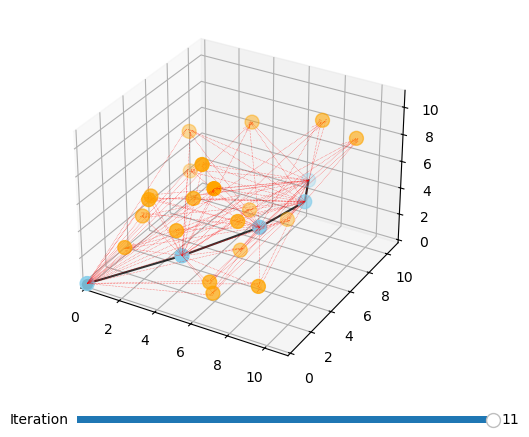

In [2]:
main()

In [3]:
generate_matching_residual_code(print_code=True)

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

#include <sym/pose3.h>

namespace sym {

/**
 * Residual from a relative translation mesurement of a 3D pose to a landmark.
 *
 * Args:
 *     world_T_body: 3D pose of the robot in the world frame
 *     world_t_landmark: World location of the landmark
 *     body_t_landmark: Measured body-frame location of the landmark
 *     sigma: Isotropic standard deviation of the measurement [m]
 *     jacobian: (3x6) jacobian of res wrt arg world_T_body (6)
 *     hessian: (6x6) Gauss-Newton hessian for arg world_T_body (6)
 *     rhs: (6x1) Gauss-Newton rhs for arg world_T_body (6)
 */
template <typename Scalar>
void MatchingFactor(const sym::Pose3<Scalar>& world_T_body,
           

In [4]:
generate_odometry_residual_code(print_code=True)

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

#include <sym/pose3.h>

namespace sym {

/**
 * Residual on the relative pose between two timesteps of the robot.
 *
 * Args:
 *     world_T_a: First pose in the world frame
 *     world_T_b: Second pose in the world frame
 *     a_T_b: Relative pose measurement between the poses
 *     diagonal_sigmas: Diagonal standard deviation of the tangent-space error
 *     epsilon: Small number for singularity handling
 *     jacobian: (6x12) jacobian of res wrt args world_T_a (6), world_T_b (6)
 *     hessian: (12x12) Gauss-Newton hessian for args world_T_a (6), world_T_b (6)
 *     rhs: (12x1) Gauss-Newton rhs for args world_T_a (6), world_T_b (6)
 */
template <typename Scalar>
vo